### Importing Libraries

In [1]:
import torch
import cv2, numpy as np, matplotlib.pyplot as plt
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

In [2]:
class GradCAM:
  def __init__(self, model, target_layer):
      self.model = model
      self.target_layer = target_layer
      self.gradients = None
      self.activations = None
      self.hook_layers()

  def hook_layers(self):
      def forward_hook(module, input, output):
          self.activations = output.detach()

      def backward_hook(module, grad_input, grad_output):
          self.gradients = grad_output[0].detach()

      self.target_layer.register_forward_hook(forward_hook)

      self.target_layer.register_full_backward_hook(backward_hook)


  def generate(self, input_image, target_class=None):
      self.model.eval()
      output = self.model(input_image)

      probs = torch.nn.functional.softmax(output, dim=1)
      if target_class is None:
          target_class = output.argmax(dim=1).item()

      confidence = probs[0, target_class].item() * 100

      self.model.zero_grad()
      class_score = output[0, target_class]
      class_score.backward()

      weights = self.gradients.mean(dim=(2, 3), keepdim=True)
      cam = (weights * self.activations).sum(dim=1).squeeze()
      cam = torch.relu(cam)

      cam -= cam.min()
      cam /= cam.max()
      cam = cam.cpu().numpy()

      return cam, target_class, confidence

Predicted Class: Cancerous (99.97%)
Suspicious Cancerous Area detected



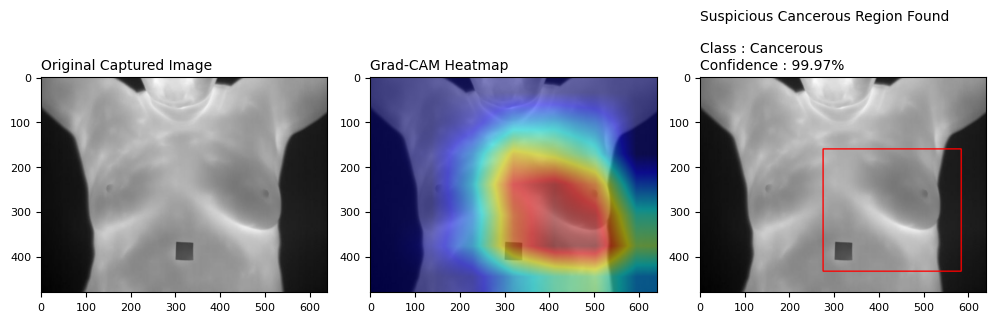

In [7]:
def predict(img_path, model_path='/content/drive/MyDrive/ResNet_SavedModels/NF2_breast_cancer_resnet18_[Epoch5_Valloss_0.0134_Trainloss_0.0022].pth') :

  transform = transforms.Compose([
      transforms.Grayscale(num_output_channels=3),
      transforms.Resize((224, 224)),
      transforms.ToTensor(), # rearrange (C, H, W)
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # output = (input - mean) / std
  ])

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  # torch.serialization.add_safe_globals([models.ResNet])

  model = models.resnet18(weights=None)
  model.fc = nn.Sequential(
      nn.Dropout(0.5),
      nn.Linear(model.fc.in_features, 2)
  )

  state_dict = torch.load(model_path, map_location="cpu")

  model.load_state_dict(state_dict)

  # model.eval()

  target_layer = model.layer4[1].conv2
  grad_cam = GradCAM(model, target_layer)

  original_img = cv2.imread(img_path)

  if original_img is None : return "Invalid Image : Cannot read image."

  original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
  pil_img = Image.fromarray(original_img)

  input_tensor = transform(pil_img).unsqueeze(0)

  cam, predicted_class, confidence = grad_cam.generate(input_tensor)
  class_names = ['Healthy', 'Cancerous']
  predicted_label = class_names[predicted_class]

  print(f"Predicted Class: {predicted_label} ({confidence:.2f}%)")

  fontsize = 10
  plt.rc('font', size = fontsize - 2)

  if predicted_class == 1:

    plt.figure(figsize=(10, 7))

    print("Suspicious Cancerous Area detected\n")

    cam_resized = cv2.resize(cam, (original_img.shape[1], original_img.shape[0]))
    threshold = 0.6
    cam_thresholded = (cam_resized > threshold).astype(np.uint8) * 255

    contours, _ = cv2.findContours(cam_thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    boxed_img = original_img.copy()

    for cnt in contours:

        x, y, w, h = cv2.boundingRect(cnt)

        if w * h < 500:
            continue

        cv2.rectangle(boxed_img, (x, y), (x + w, y + h), (255, 0, 0), 2)

    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = np.uint8(0.5 * heatmap + 0.5 * original_img)


    plt.subplot(1, 3, 1)
    plt.title(f"Original Captured Image", loc='left', fontsize=fontsize)
    plt.imshow(original_img)
    # plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Grad-CAM Heatmap", loc='left', fontsize=fontsize)
    plt.imshow(overlay)
    # plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title(f"Suspicious Cancerous Region Found \n\nClass : {predicted_label} \nConfidence : {confidence:.2f}%", loc='left', fontsize=fontsize)
    plt.imshow(boxed_img)
    # plt.axis("off")

    plt.tight_layout()
    plt.show()

  else:

      plt.figure(figsize=(10, 8))

      print("Showing soft Grad-CAM overlay...\n")

      cam_resized = cv2.resize(cam, (original_img.shape[1], original_img.shape[0]))

      cam_soft = cam_resized * 0.5  # reducing intensity for healthy cases

      heatmap = cv2.applyColorMap(np.uint8(255 * cam_soft), cv2.COLORMAP_JET)
      heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
      overlay = np.uint8(0.3 * heatmap + 0.7 * original_img)  # soft overlay

      plt.subplot(1, 3, 1)
      plt.title(f"Original Captured Image", loc='left', fontsize=fontsize)
      plt.imshow(original_img)
      # plt.axis("off")

      plt.subplot(1, 3, 2)
      plt.title(f"Grad-CAM Heatmap", loc='left', fontsize=fontsize)
      plt.imshow(overlay)
      # plt.axis("off")

      plt.subplot(1, 3, 3)
      plt.title(f"No Cancerous Region Found \n\nClass: {predicted_label} \nConfidence : {confidence:.2f}%", loc='left', fontsize=fontsize)
      plt.imshow(original_img)
      # plt.axis("off")

      plt.tight_layout()
      plt.show()

predict("/content/drive/MyDrive/Unseen_BCD_Dataset/sick20.jpg")